In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_energy = pd.read_csv("data/OWID_energy/owid-energy-data.csv")
print(df_energy["country"].value_counts())
print(df_energy.columns)

Canada         121
Germany        121
Nigeria        121
Hungary        121
Norway         121
              ... 
Palestine       23
South Sudan     21
Kosovo          20
Montenegro      20
Timor           14
Name: country, Length: 242, dtype: int64
Index(['iso_code', 'country', 'year', 'coal_prod_change_pct',
       'coal_prod_change_twh', 'gas_prod_change_pct', 'gas_prod_change_twh',
       'oil_prod_change_pct', 'oil_prod_change_twh', 'energy_cons_change_pct',
       ...
       'solar_elec_per_capita', 'solar_energy_per_capita', 'gdp',
       'wind_share_elec', 'wind_cons_change_pct', 'wind_share_energy',
       'wind_cons_change_twh', 'wind_consumption', 'wind_elec_per_capita',
       'wind_energy_per_capita'],
      dtype='object', length=122)


In [3]:
df_co2 = pd.read_csv("data/OWID_CO2/owid-co2-data.csv")
print(df_co2["country"].value_counts())
print(df_co2.columns)

United Kingdom          271
Europe                  271
World                   271
EU-28                   271
Europe (excl. EU-27)    271
                       ... 
Micronesia (country)     29
Micronesia               27
Wallis and Futuna        20
Timor                    19
Kosovo                   13
Name: country, Length: 244, dtype: int64
Index(['iso_code', 'country', 'year', 'co2', 'consumption_co2',
       'co2_growth_prct', 'co2_growth_abs', 'trade_co2', 'co2_per_capita',
       'consumption_co2_per_capita', 'share_global_co2', 'cumulative_co2',
       'share_global_cumulative_co2', 'co2_per_gdp', 'consumption_co2_per_gdp',
       'co2_per_unit_energy', 'coal_co2', 'cement_co2', 'flaring_co2',
       'gas_co2', 'oil_co2', 'other_industry_co2', 'cement_co2_per_capita',
       'coal_co2_per_capita', 'flaring_co2_per_capita', 'gas_co2_per_capita',
       'oil_co2_per_capita', 'other_co2_per_capita', 'trade_co2_share',
       'share_global_cement_co2', 'share_global_coal_co2',
 

In [4]:
relevant_energy = df_energy[["iso_code", "country", "year",
                             "gdp", "population",
                             "primary_energy_consumption", "electricity_generation",
                             "energy_per_gdp", "energy_per_capita",
                             "nuclear_electricity", "nuclear_share_elec",
                             "nuclear_consumption", "nuclear_share_energy"]]
relevant_co2 = df_co2[["iso_code", "country", "year",
                       "population", "gdp", "primary_energy_consumption",
                       "co2", "methane", "total_ghg"]]

joined = relevant_energy.join(
    relevant_co2.set_index(["iso_code", "country", "year"]),
    on = ["iso_code", "country", "year"], rsuffix = "_co2", lsuffix = "_energy"
).set_index(["iso_code", "country", "year"])

In [5]:
value_exists = joined[joined["co2"].notna()].groupby(["iso_code", "year"]).count()
(value_exists == 0).sum()

comparevals = ["gdp", "population", "primary_energy_consumption"]
energy_vals = [x+"_energy" for x in comparevals]
co2_vals = [x+"_co2" for x in comparevals]

val_diffs = (joined[energy_vals] - joined[co2_vals].values)[joined["primary_energy_consumption_energy"].notna()]
mean_diff = val_diffs.groupby("country").mean()
max_vals = joined[joined["primary_energy_consumption_energy"].notna()][energy_vals].groupby("country").max() * 100

relative_diff = mean_diff / max_vals.loc[mean_diff.index] * 100
print(relative_diff["gdp_energy"][relative_diff["gdp_energy"].isna()].index)

print(relative_diff["gdp_energy"].dropna().abs().sort_values())

# while the values for GDP as well as population differ somewhat between the two datasets, these differences are relatively small.
# For lack of a better option, the differences will remain reconciled, and the data from the Energy dataset considered
# authorative, as it also forms the basis for all other considerations in this project.

df = joined[energy_vals +
            [x for x in relevant_energy.columns if x not in comparevals and x not in joined.index.names] +
            [x for x in relevant_co2.columns if x not in comparevals and x not in joined.index.names]]
df.columns = comparevals + list(df.columns[3:])

Index(['Africa', 'American Samoa', 'Antigua and Barbuda', 'Aruba',
       'Asia Pacific', 'Bahamas', 'Belize', 'Bermuda', 'Bhutan',
       'British Virgin Islands', 'Brunei', 'CIS', 'Cayman Islands',
       'Central America', 'Cook Islands', 'Czechoslovakia', 'Eastern Africa',
       'Eritrea', 'Europe', 'Europe (other)', 'Faeroe Islands',
       'Falkland Islands ', 'Fiji', 'French Guiana', 'French Polynesia',
       'Gibraltar', 'Greenland', 'Grenada', 'Guadeloupe', 'Guam', 'Guyana',
       'Kiribati', 'Kosovo', 'Macau', 'Maldives', 'Martinique',
       'Middle Africa', 'Middle East', 'Montserrat', 'Nauru',
       'Netherlands Antilles', 'New Caledonia', 'Niue', 'North America',
       'Northern Mariana Islands', 'OPEC', 'Other Asia & Pacific', 'Other CIS',
       'Other Caribbean', 'Other Middle East', 'Other Northern Africa',
       'Other South America', 'Other Southern Africa', 'Papua New Guinea',
       'Reunion', 'Saint Helena', 'Saint Kitts and Nevis',
       'Saint Pierre and

In [120]:
data = df[["population", "gdp", "co2", "total_ghg",
           "primary_energy_consumption", "electricity_generation",
           "nuclear_consumption", "nuclear_electricity"]]

data["co2_per_capita"] = df["co2"] / df["population"] * 1e6
data["co2_per_gdp"] = df["co2"] / df["gdp"] * 1e6
data["co2_per_kwh"] = df["co2"] / df["primary_energy_consumption"]
data["total_ghg_per_capita"] = df["total_ghg"] / df["population"]
data["total_ghg_per_gdp"] = df["total_ghg"] / df["gdp"]
data["energy_per_capita"] = df["primary_energy_consumption"] / df["population"]
data["energy_per_gdp"] = df["primary_energy_consumption"] / df["gdp"]
data["energy_normalized"] = df["primary_energy_consumption"] / df["primary_energy_consumption"].unstack(level=-1).T.max()
data["electricity_per_capita"] = df["electricity_generation"] / df["population"]
data["electricity_per_gdp"] = df["electricity_generation"] / df["gdp"]

data["nuclear_consumption_per_capita"] = df["nuclear_consumption"] / df["population"]
data["nuclear_consumption_per_gdp"] = df["nuclear_consumption"] / df["gdp"]
data["nuclear_electricity_per_capita"] = df["nuclear_electricity"] / df["population"]
data["nuclear_electricity_per_gdp"] = df["nuclear_electricity"] / df["gdp"]

data["nuclear_energy_share"] = df["nuclear_consumption"] / df["primary_energy_consumption"]
data["nuclear_energy_share_pct"] = df["nuclear_consumption"] / df["primary_energy_consumption"] * 100
data["nuclear_electricity_share"] = df["nuclear_electricity"] / df["electricity_generation"]
data["nuclear_electricity_share_pct"] = df["nuclear_electricity"] / df["electricity_generation"] * 100

iso_name_dict = {iso:country for iso,country,year in data.index}

<ipython-input-120-4ce9d5c08591>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["co2_per_capita"] = df["co2"] / df["population"] * 1e6
<ipython-input-120-4ce9d5c08591>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["co2_per_gdp"] = df["co2"] / df["gdp"] * 1e6
<ipython-input-120-4ce9d5c08591>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [7]:
nuclear_countries = data[data["nuclear_consumption"] > 0].groupby(["iso_code", "country"]).any().index
country_info = pd.DataFrame(index=nuclear_countries)
total_nuclear_energy = data["nuclear_consumption"].reset_index().groupby(["iso_code","country"]).sum().drop("year", axis=1)
country_info["total_nuclear_energy"] = total_nuclear_energy.loc[country_info.index]
total_energy = data["primary_energy_consumption"].reset_index().groupby(["iso_code","country"]).sum().drop("year", axis=1)
country_info["total_energy"] = total_energy.loc[country_info.index]
country_info["lifetime_nuclear_share"] = country_info["total_nuclear_energy"] / country_info["total_energy"]

country_info.sort_values(by="lifetime_nuclear_share")

,,total_nuclear_energy,total_energy,lifetime_nuclear_share
iso_code,country,,,
KAZ,Kazakhstan,6.913,23264.028,0.000297
IRN,Iran,101.331,68665.291,0.001476
ITA,Italy,249.701,96912.559,0.002577
CHN,China,5963.849,742644.728,0.008031
BRA,Brazil,805.832,97896.846,0.008231
NLD,Netherlands,479.724,49581.065,0.009676
IND,India,1762.044,182071.683,0.009678
MEX,Mexico,715.345,71764.386,0.009968
PAK,Pakistan,228.372,22064.271,0.010350


<AxesSubplot:ylabel='iso_code,country'>

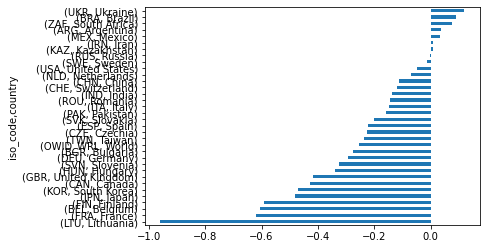

In [110]:
def get_corr(df):
    df.columns = df.columns.get_level_values(0)
    c = df.corr()
    return c.iloc[0,1]

yearly_change = data.unstack(level=[0,1]).diff()[["nuclear_energy_share", "co2_per_kwh"]]
yearly_change_corr = yearly_change.groupby(level=[1,2], axis=1).apply(get_corr).dropna()
yearly_change_corr.sort_values().plot.barh()

In [136]:
def make_country_plots(iso):
    d = data.loc[(iso, iso_name_dict[iso])]
    fig1 = d[["co2_per_kwh", "nuclear_energy_share", "energy_normalized"]].plot()
    fig2 = d.diff().plot.scatter("co2_per_kwh", "nuclear_energy_share")
    plt.show()

<ipython-input-136-fc24bb50ca1a>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = data.loc[(iso, iso_name_dict[iso])]


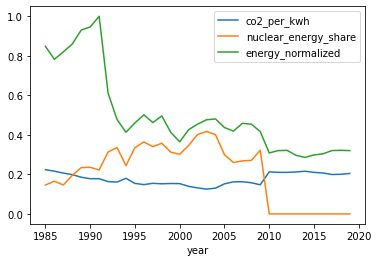

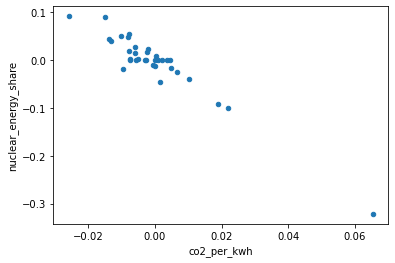

In [138]:
# case study: Lithuania
make_country_plots("LTU")
# Lithuania shut down their nuclear generators in 2004 and 2009, which each time was followed by an
# increase in co2 emissions.

<ipython-input-136-fc24bb50ca1a>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = data.loc[(iso, iso_name_dict[iso])]


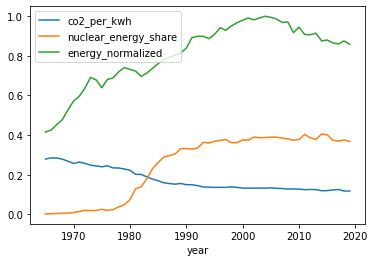

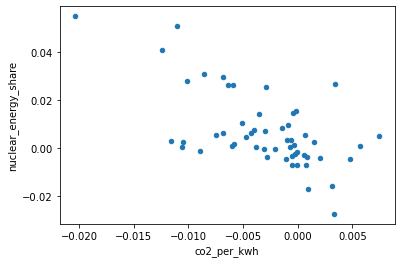

In [137]:
# case study: France
make_country_plots("FRA")
# The strong expansion of nuclear energy use in the 1980s corresponded to a sharp decline in
# the "dirtiniess" of the energy used.

<ipython-input-136-fc24bb50ca1a>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = data.loc[(iso, iso_name_dict[iso])]


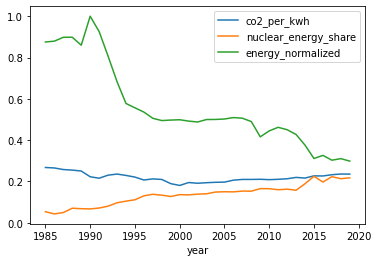

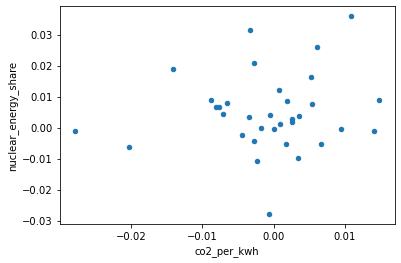

In [139]:
# case study: Ukraine
make_country_plots("UKR")
# nuclear share steadily increases, but co2 emissions per kWh also increases.
# At the same time, the overall energy use seems to decline, so the nuclear share
# increase is likely due to that rather than new nuclear power plants.

<ipython-input-136-fc24bb50ca1a>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = data.loc[(iso, iso_name_dict[iso])]


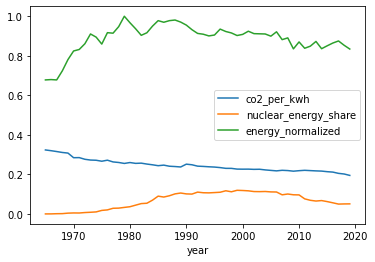

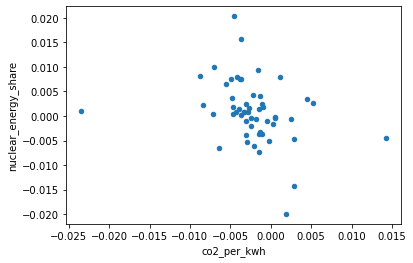

In [140]:
# case study: Germany
make_country_plots("DEU")
# There is no real correlation between change nuclear energy share and the co2 per kwh of energy.
# The steady reduction in co2 per kwh is likely due to other green energy initiatives.

<ipython-input-136-fc24bb50ca1a>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = data.loc[(iso, iso_name_dict[iso])]


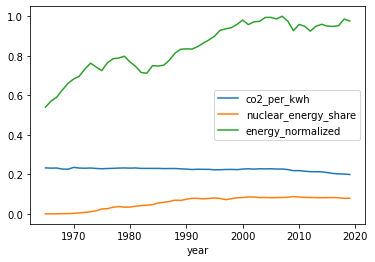

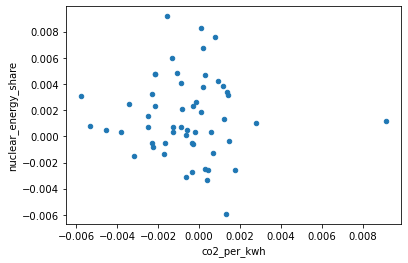

In [141]:
# case study: USA
make_country_plots("USA")
# the slow increase of nuclear energy share corresponds to almost constant co2 per kwh.
# At the same time, the slight decline in the 2010s correspons to a steady nuclear share.
# Thus, there is no real correlation to be found here.

<ipython-input-136-fc24bb50ca1a>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = data.loc[(iso, iso_name_dict[iso])]


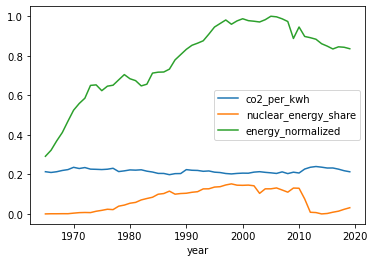

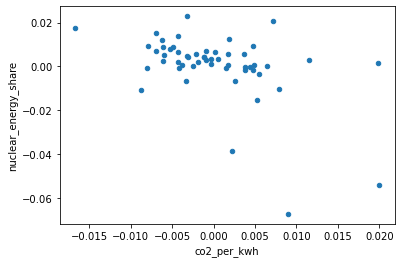

In [143]:
# case study: Japan
make_country_plots(("JPN"))
# Very visible is the sharp decline in nuclear energy share following the disaster at Fukushima
# in 2011. This corresponds to an increase in co2 per kwh, which likely contributes to the
# overall somewhat significant correlation.

<ipython-input-136-fc24bb50ca1a>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = data.loc[(iso, iso_name_dict[iso])]


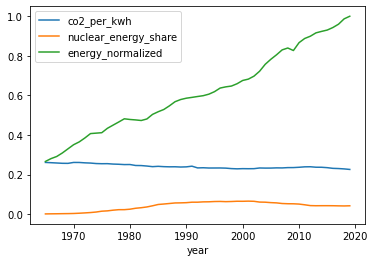

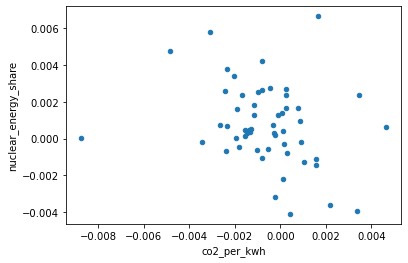

In [146]:
# case study: World
make_country_plots("OWID_WRL")
# the overall correlation is very slight, but does exist.
# Specifically the decrease in nuclear share in the 2000s and 2010s
# is accompanied by a constant or slightly increasing co2 per kwh value.